# 4. Clustering
---

In [1]:
import sys
sys.path.insert(1, '../../utils')

import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds

data: pd.DataFrame = pd.read_csv('data/prepared_mm.csv', sep=';')
data.pop('DEATH_EVENT')

v1 = 0 #age
v2 = 3 #platelets

print(data.columns)

N_CLUSTERS = [2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
rows, cols = ds.choose_grid(len(N_CLUSTERS))

Index(['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium', 'time', 'anaemia', 'diabetes',
       'high_blood_pressure', 'sex', 'smoking'],
      dtype='object')


## K-means
---

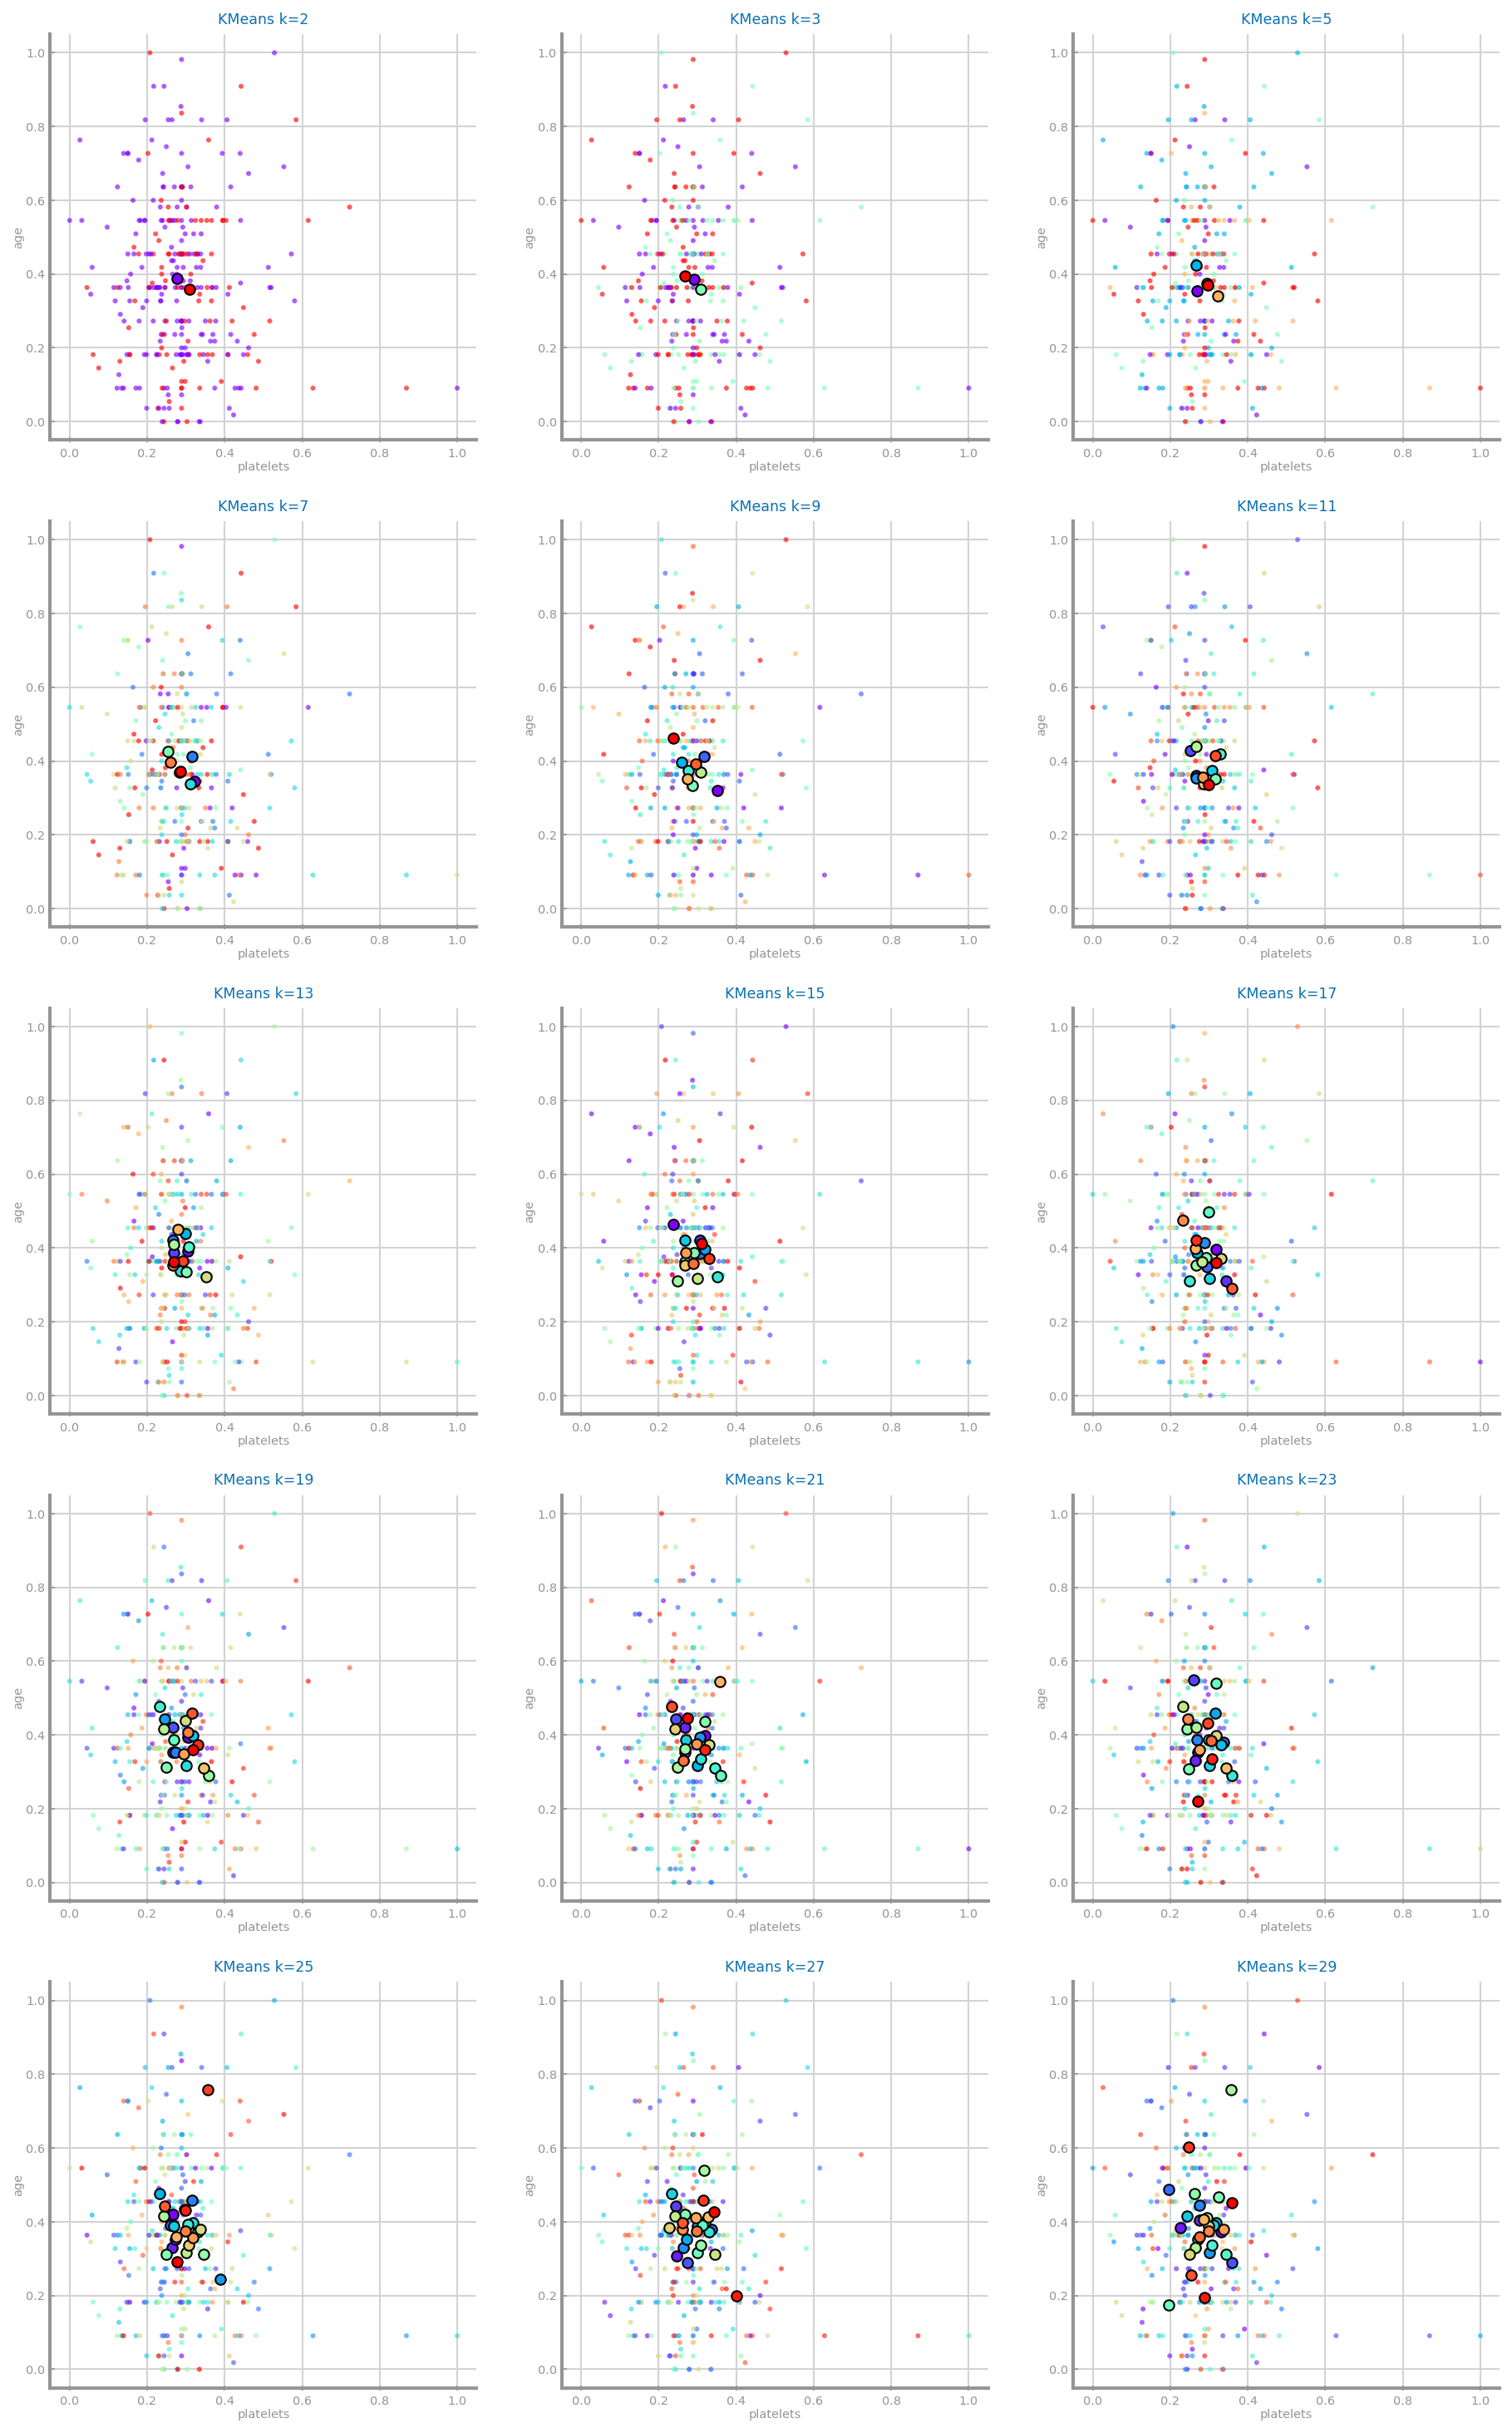

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

mse: list = []
sc: list = []
fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
    estimator = KMeans(n_clusters=k)
    estimator.fit(data)
    mse.append(estimator.inertia_)
    sc.append(silhouette_score(data, estimator.labels_))
    ds.plot_clusters(data, v2, v1, estimator.labels_.astype(float), estimator.cluster_centers_, k,
                     f'KMeans k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

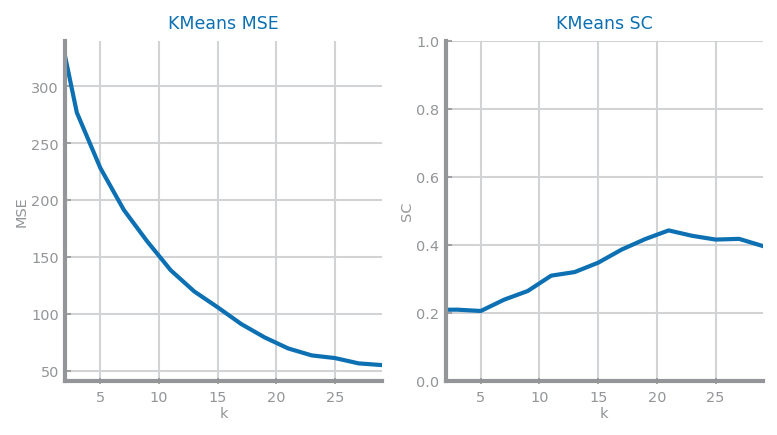

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(N_CLUSTERS, mse, title='KMeans MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(N_CLUSTERS, sc, title='KMeans SC', xlabel='k', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

## EM (Expectation-Maximization)
---

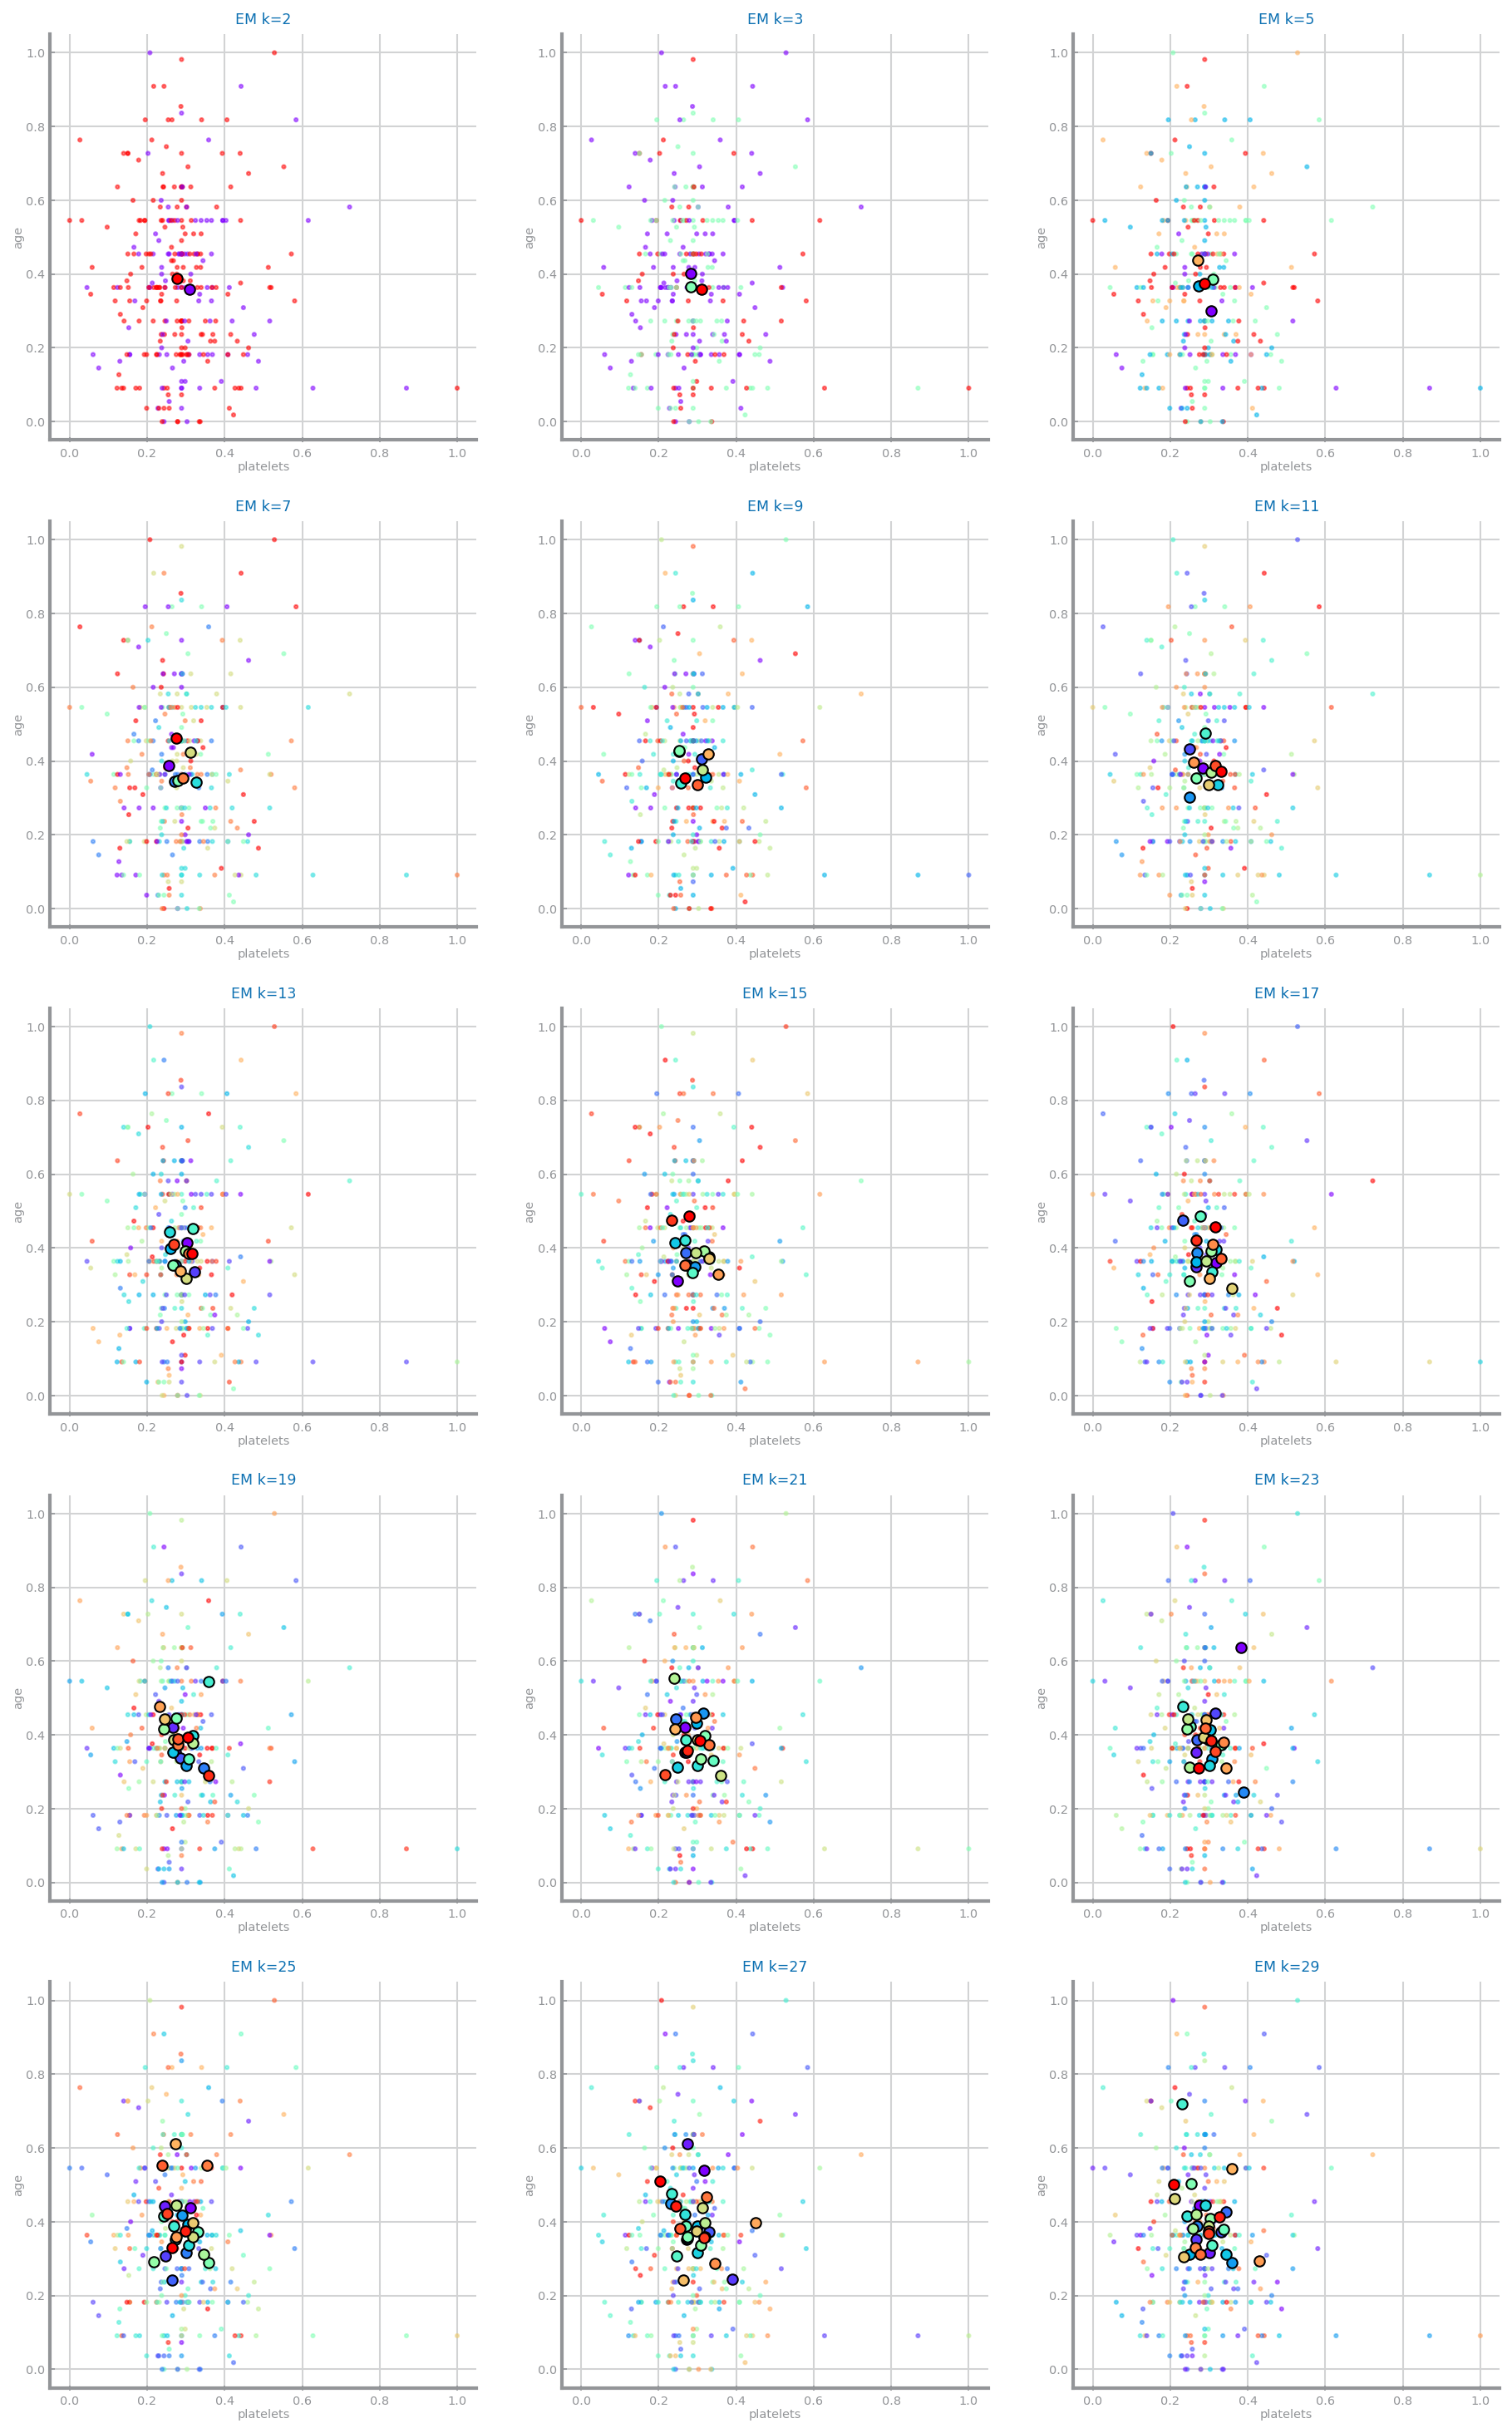

In [4]:
from sklearn.mixture import GaussianMixture

mse: list = []
sc: list = []
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
    estimator = GaussianMixture(n_components=k)
    estimator.fit(data)
    labels = estimator.predict(data)
    mse.append(ds.compute_mse(data.values, labels, estimator.means_))
    sc.append(silhouette_score(data, labels))
    ds.plot_clusters(data, v2, v1, labels.astype(float), estimator.means_, k,
                     f'EM k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()


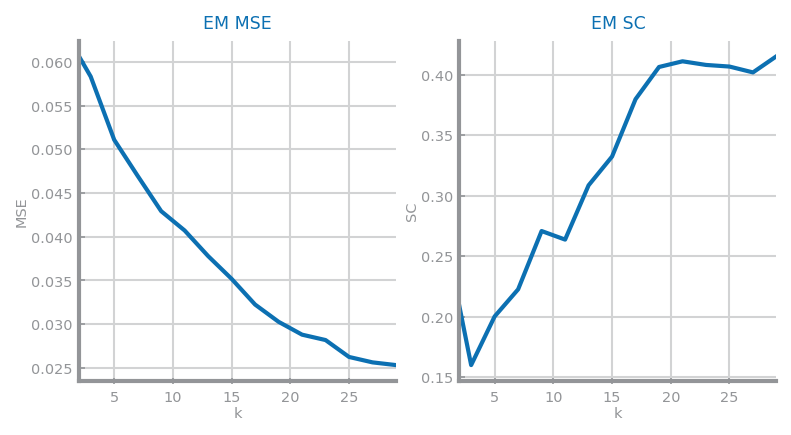

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(N_CLUSTERS, mse, title='EM MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(N_CLUSTERS, sc, title='EM SC', xlabel='k', ylabel='SC', ax=ax[0, 1])
plt.show()

## Density Based
---

### EPS - studying the maximum distance impact


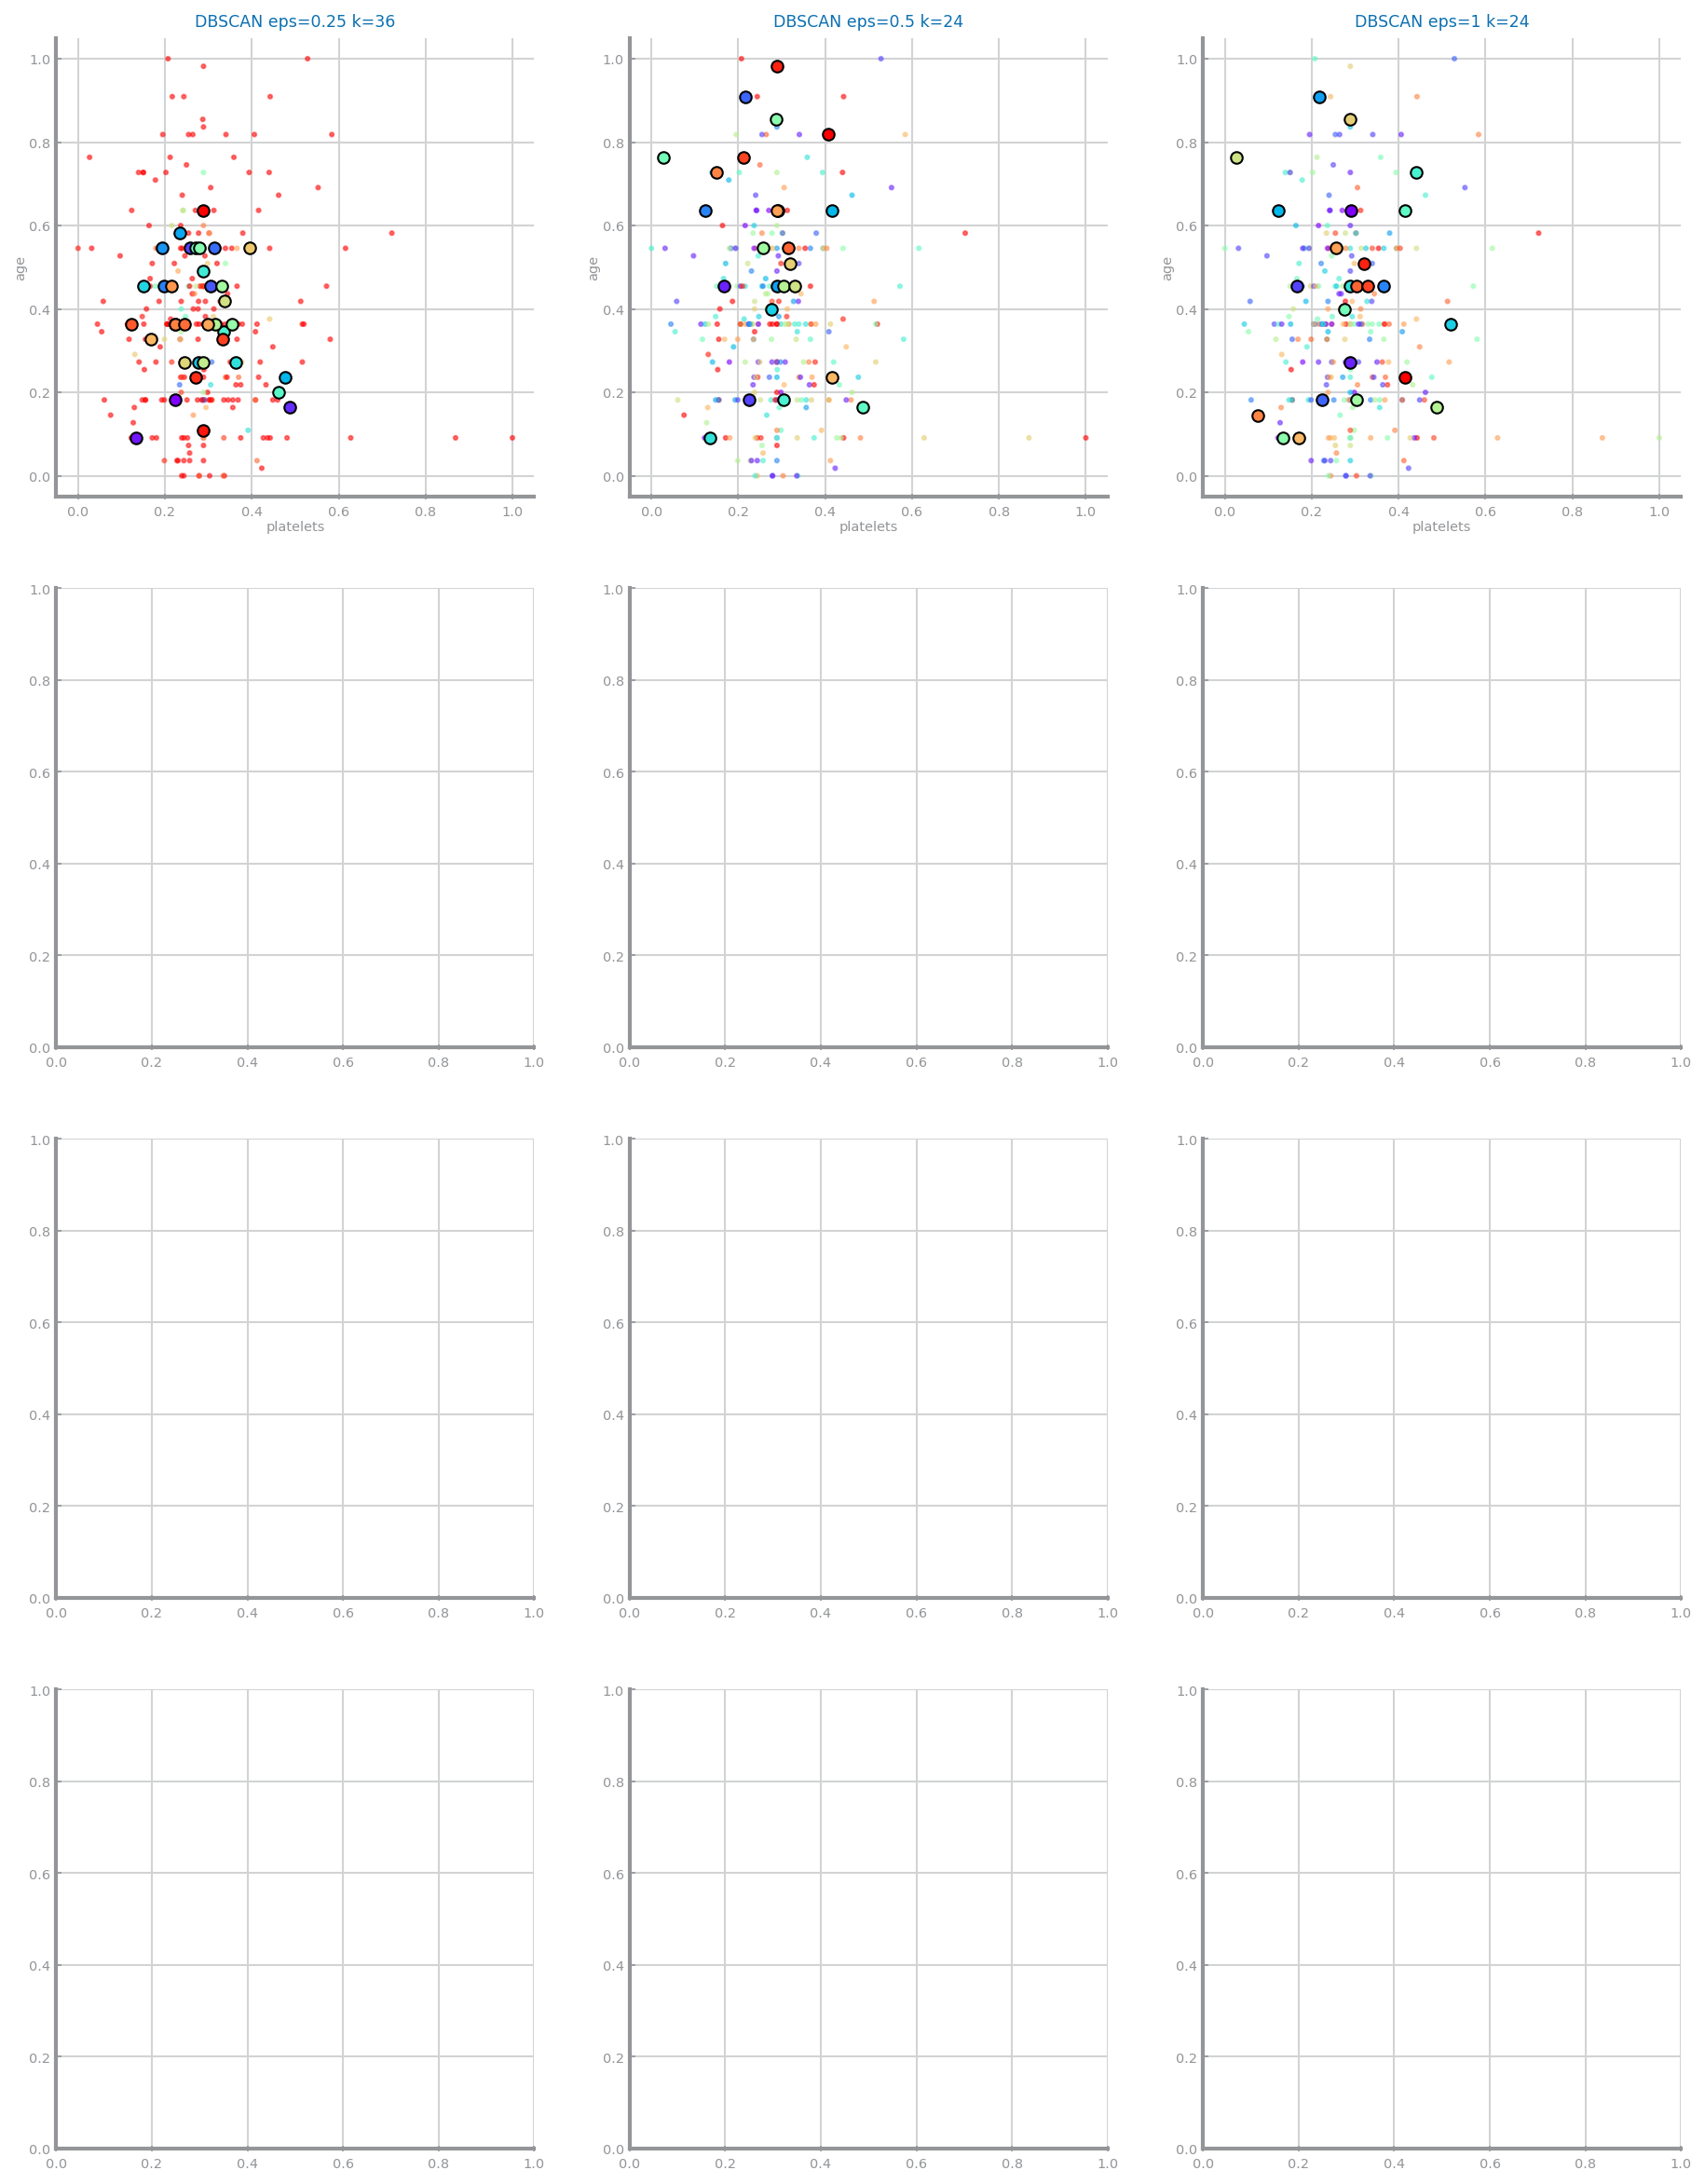

In [6]:
from sklearn.cluster import DBSCAN

EPS = [0.25, 0.5, 1, 1.25, 1.5, 2, 2.25, 2.5, 3, 3.5,] #QUESTION: too big values????????
mse: list = []
sc: list = []
rows, cols = ds.choose_grid(len(EPS))
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0

for n in range(len(EPS)):
    estimator = DBSCAN(eps=EPS[n], min_samples=2)
    estimator.fit(data)
    labels = estimator.labels_
    k = len(set(labels)) - (1 if -1 in labels else 0)
    if k > 1:
        centers = ds.compute_centroids(data, labels)
        mse.append(ds.compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        ds.plot_clusters(data, v2, v1, labels.astype(float), estimator.components_, k,
                         f'DBSCAN eps={EPS[n]} k={k}', ax=axs[i,j])
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    else:
        mse.append(0)
        sc.append(0)

plt.show()

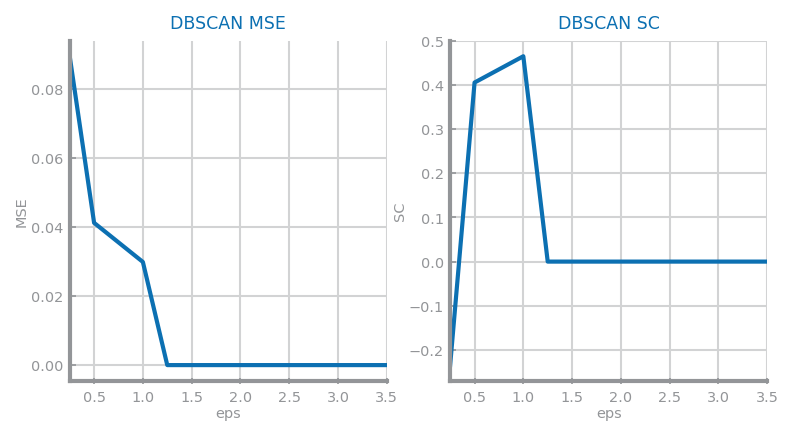

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(EPS, mse, title='DBSCAN MSE', xlabel='eps', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(EPS, sc, title='DBSCAN SC', xlabel='eps', ylabel='SC', ax=ax[0, 1])
plt.show()

### Metric

In [8]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard']
distances = []
for m in METRICS:
    dist = np.mean(np.mean(squareform(pdist(data.values, metric=m))))
    distances.append(dist)

print('AVG distances among records', distances)
#QUESTION: how to choose eps? 
distances[0] *= 0.6
distances[1] = 3.0
distances[2] *= 0.6
distances[3] *= 0.1
distances[4] *= 0.15
print('CHOSEN EPS', distances)

AVG distances among records [1.6090847364362875, 3.515860172567712, 0.9714457879785344, 0.3995390648067789, 0.8664099629709634]
CHOSEN EPS [0.9654508418617724, 3.0, 0.5828674727871206, 0.0399539064806779, 0.1299614944456445]


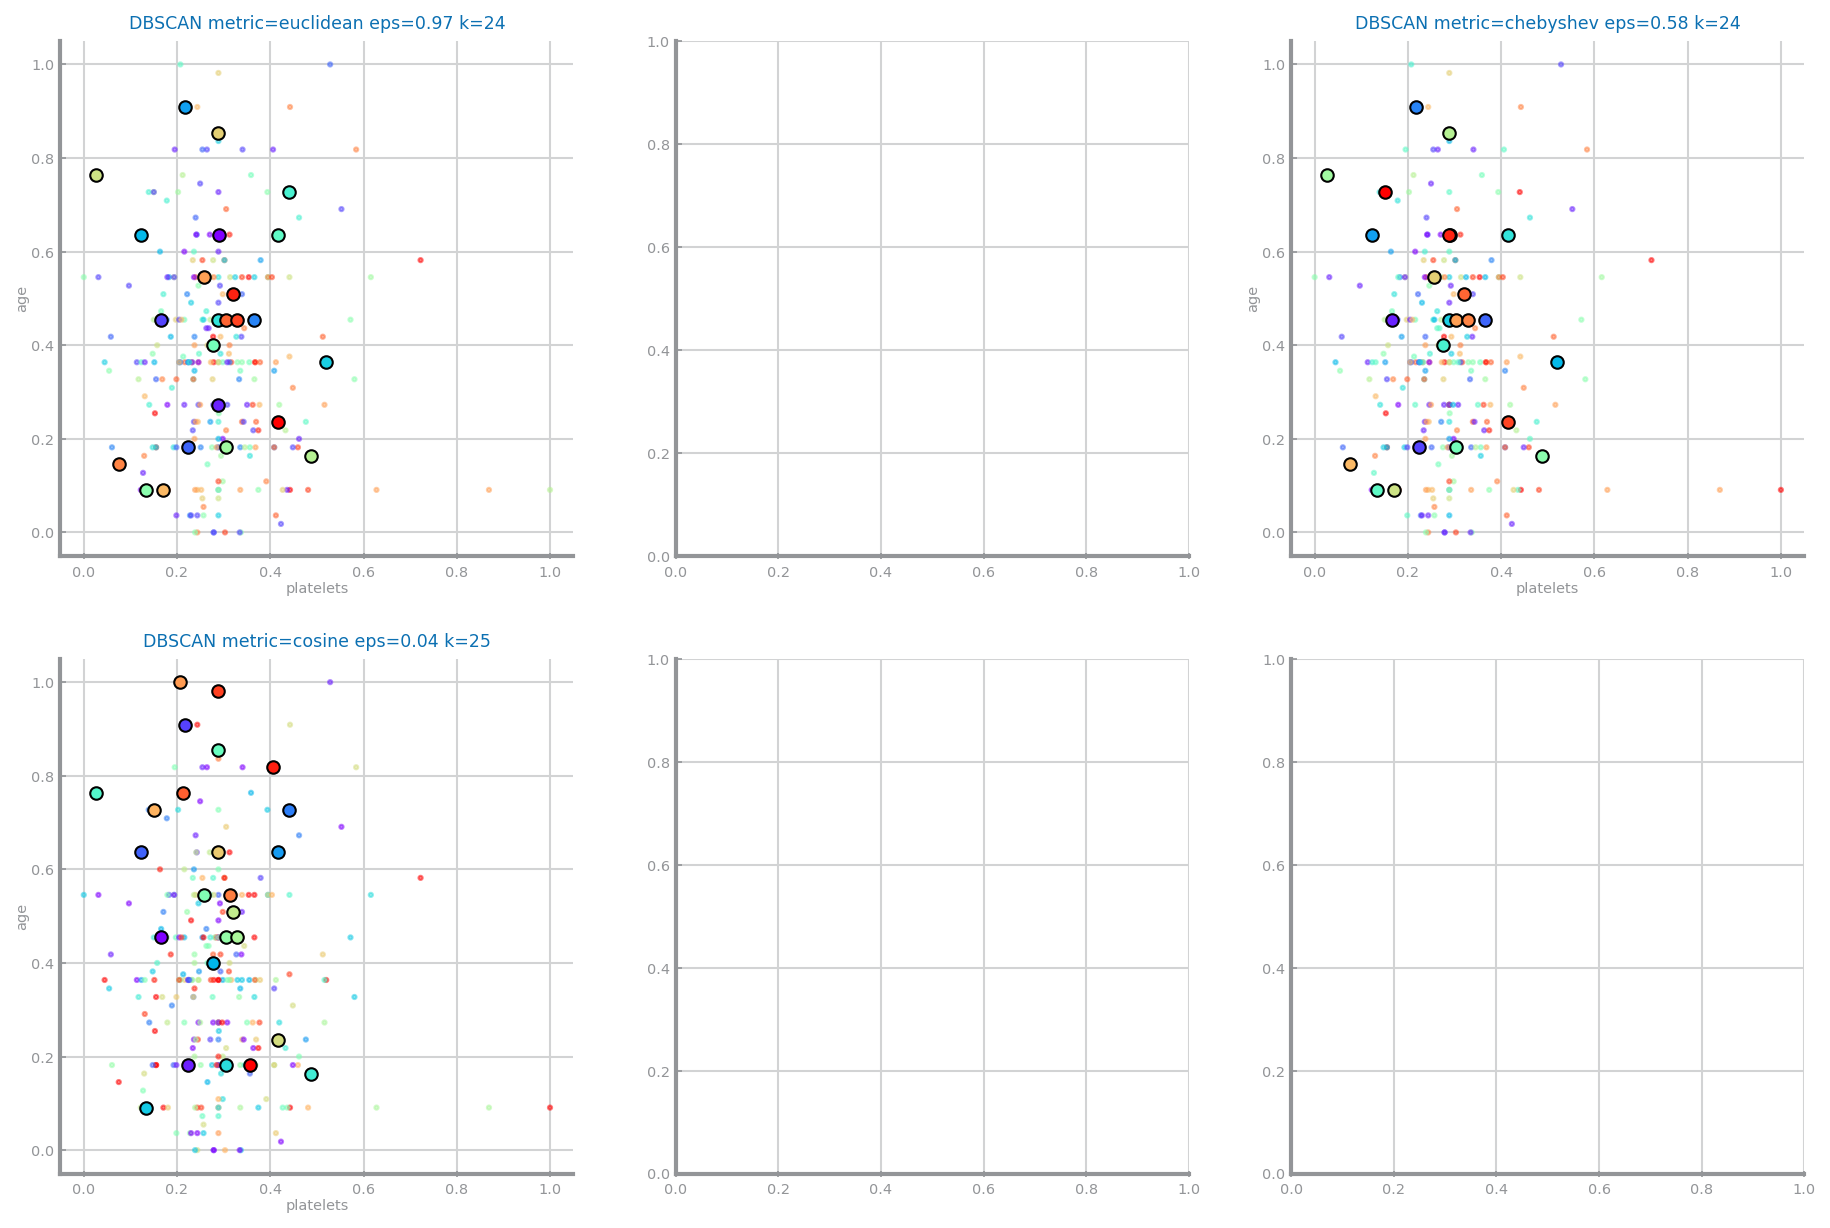

In [9]:
mse: list = []
sc: list = []
rows, cols = ds.choose_grid(len(METRICS))
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(METRICS)):
    estimator = DBSCAN(eps=distances[n], min_samples=2, metric=METRICS[n])
    estimator.fit(data)
    labels = estimator.labels_
    k = len(set(labels)) - (1 if -1 in labels else 0)
    if k > 1:
        centers = ds.compute_centroids(data, labels)
        mse.append(ds.compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        ds.plot_clusters(data, v2, v1, labels.astype(float), estimator.components_, k,
                         f'DBSCAN metric={METRICS[n]} eps={distances[n]:.2f} k={k}', ax=axs[i,j])
    else:
        mse.append(0)
        sc.append(0)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()


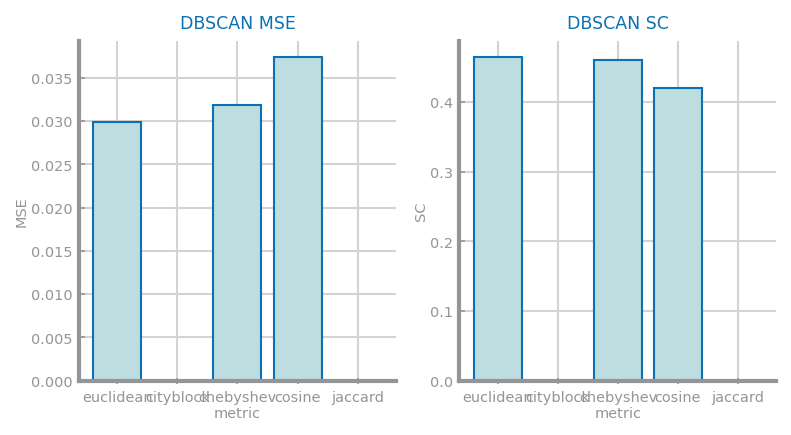

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.bar_chart(METRICS, mse, title='DBSCAN MSE', xlabel='metric', ylabel='MSE', ax=ax[0, 0])
ds.bar_chart(METRICS, sc, title='DBSCAN SC', xlabel='metric', ylabel='SC', ax=ax[0, 1])
plt.show()

## Hierarchical
---

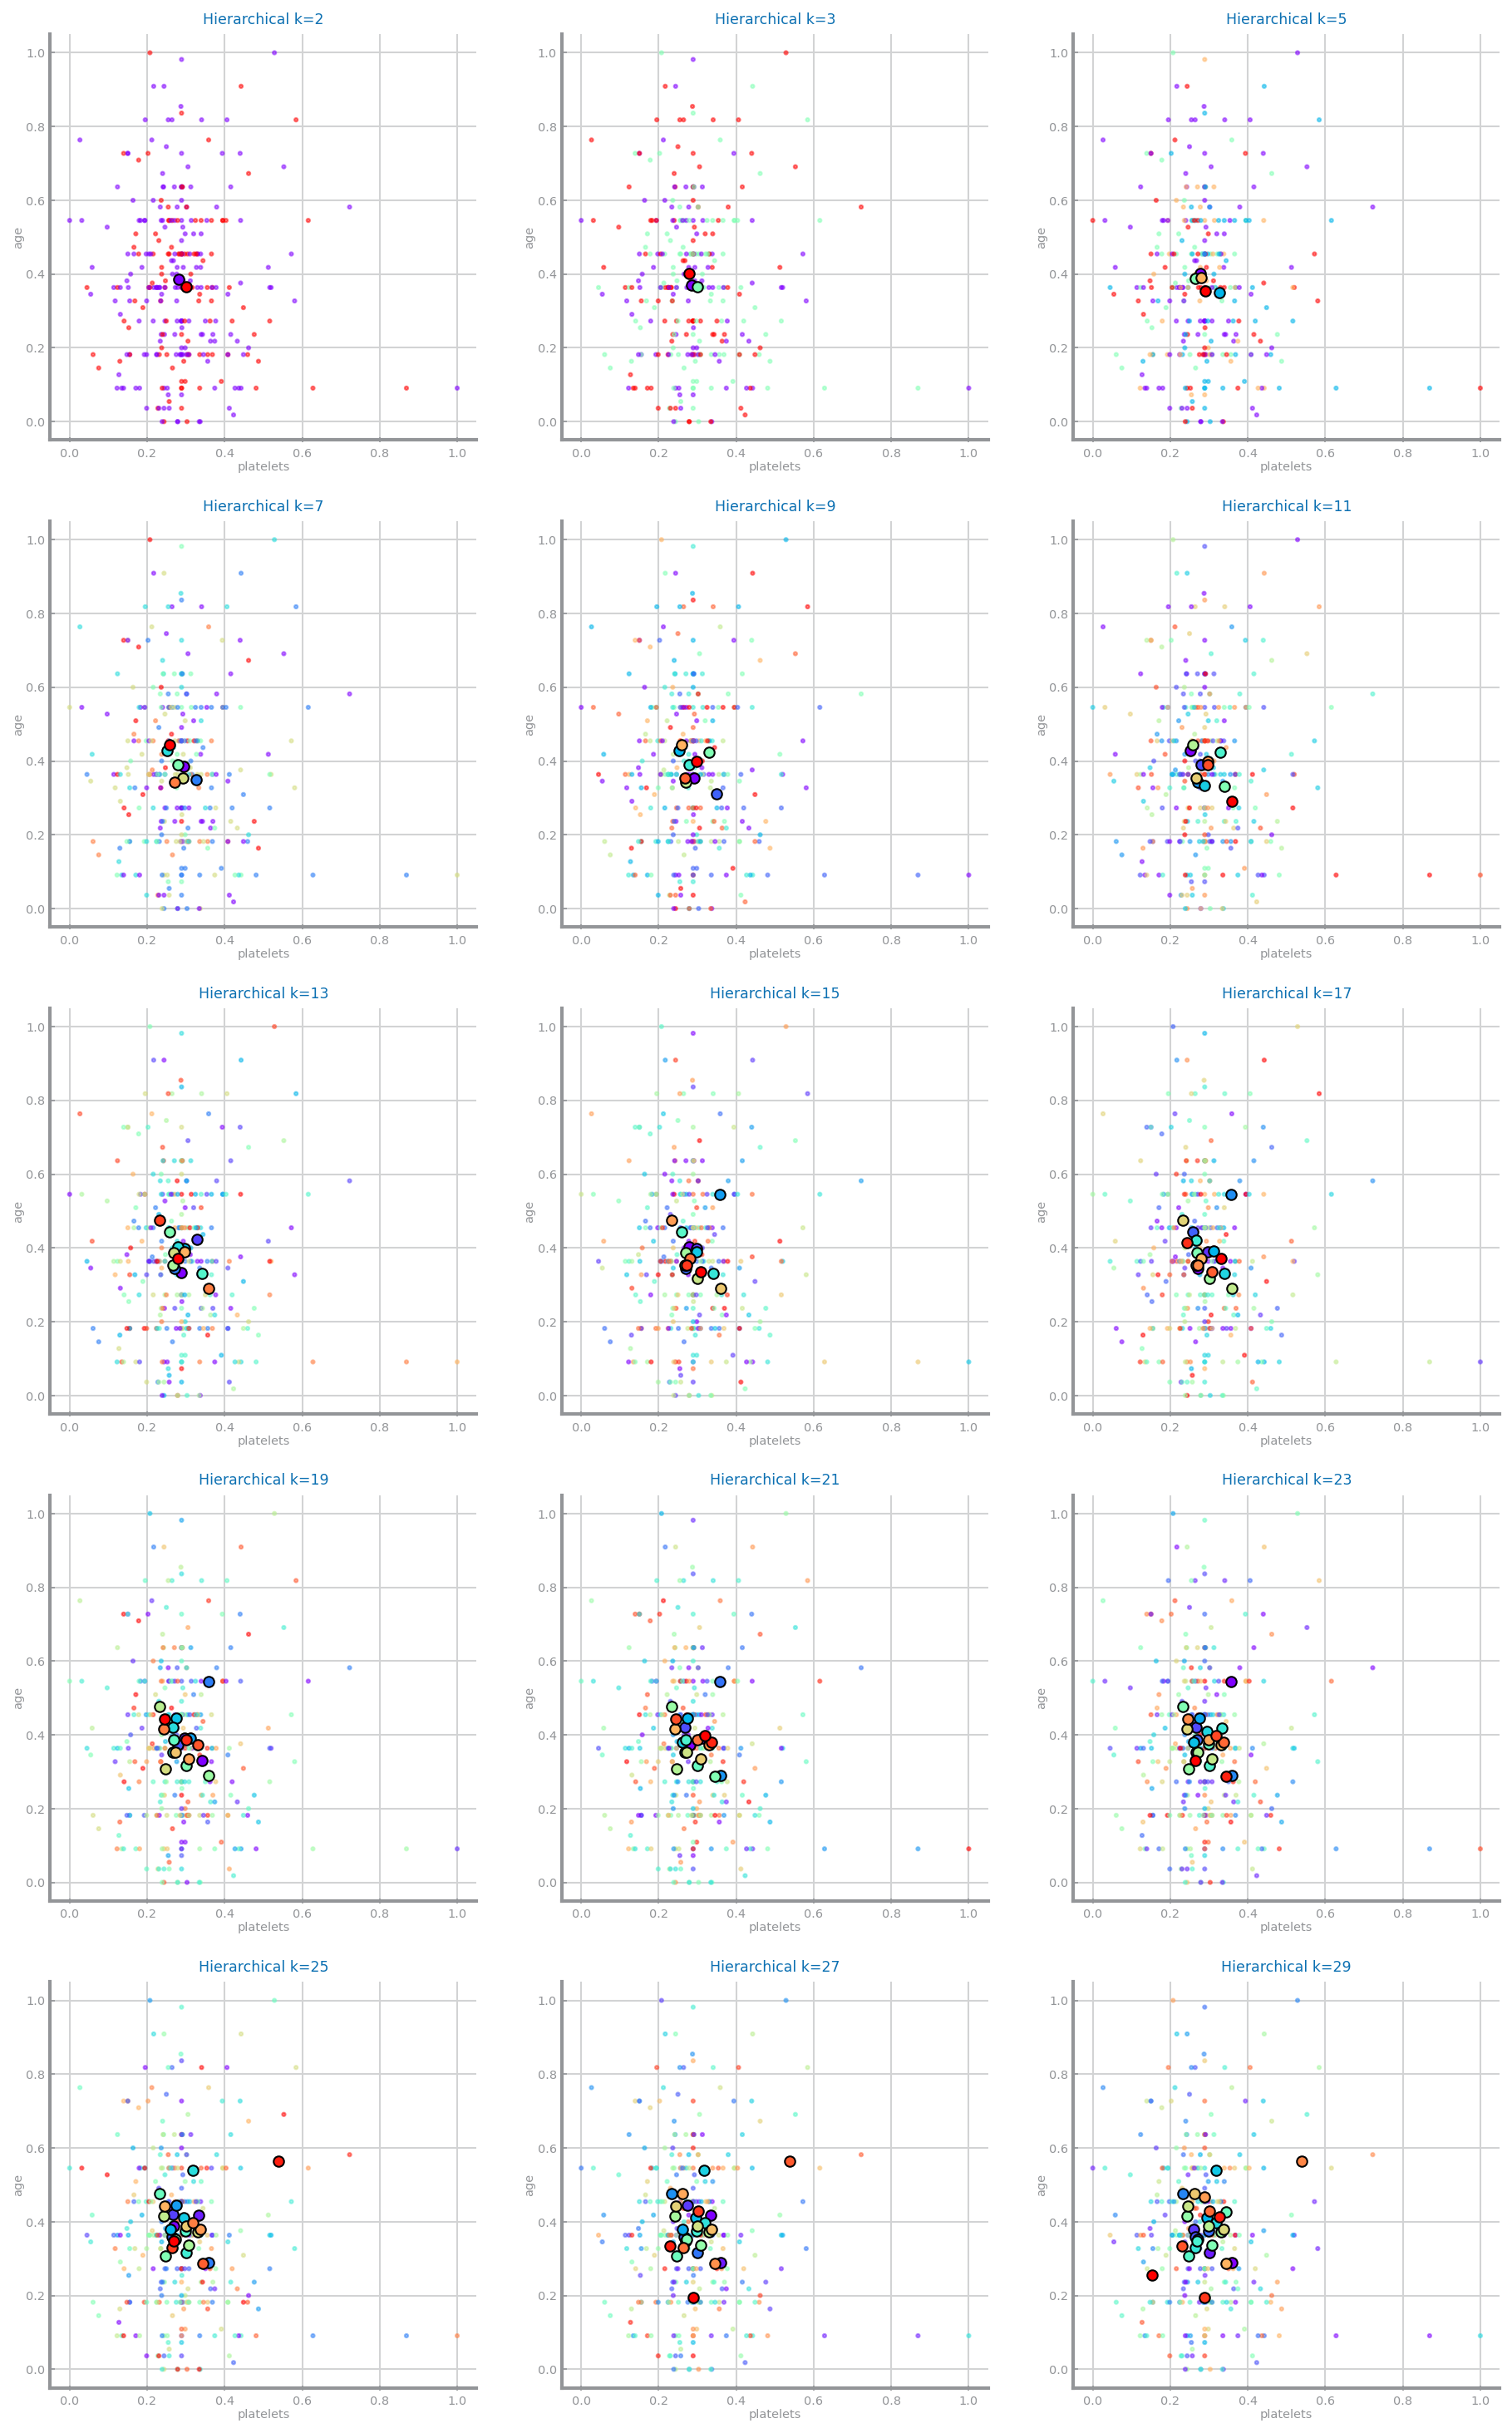

In [11]:
from sklearn.cluster import AgglomerativeClustering

mse: list = []
sc: list = []
rows, cols = ds.choose_grid(len(N_CLUSTERS))
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
    estimator = AgglomerativeClustering(n_clusters=k)
    estimator.fit(data)
    labels = estimator.labels_
    centers = ds.compute_centroids(data, labels)
    mse.append(ds.compute_mse(data.values, labels, centers))
    sc.append(silhouette_score(data, labels))
    ds.plot_clusters(data, v2, v1, labels, centers, k,
                     f'Hierarchical k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

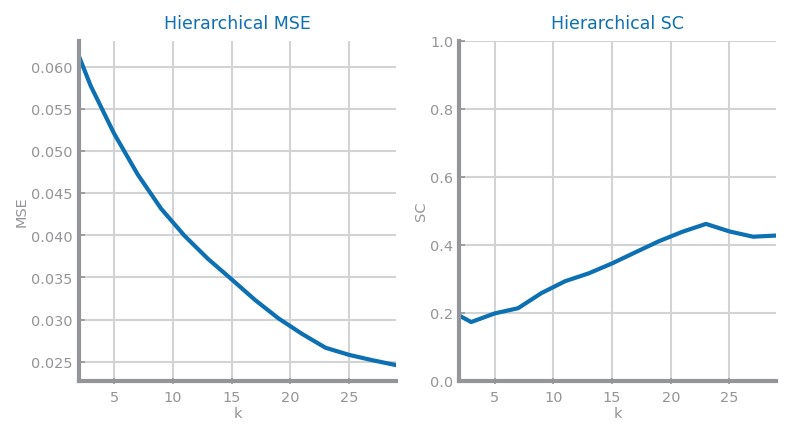

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(N_CLUSTERS, mse, title='Hierarchical MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(N_CLUSTERS, sc, title='Hierarchical SC', xlabel='k', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

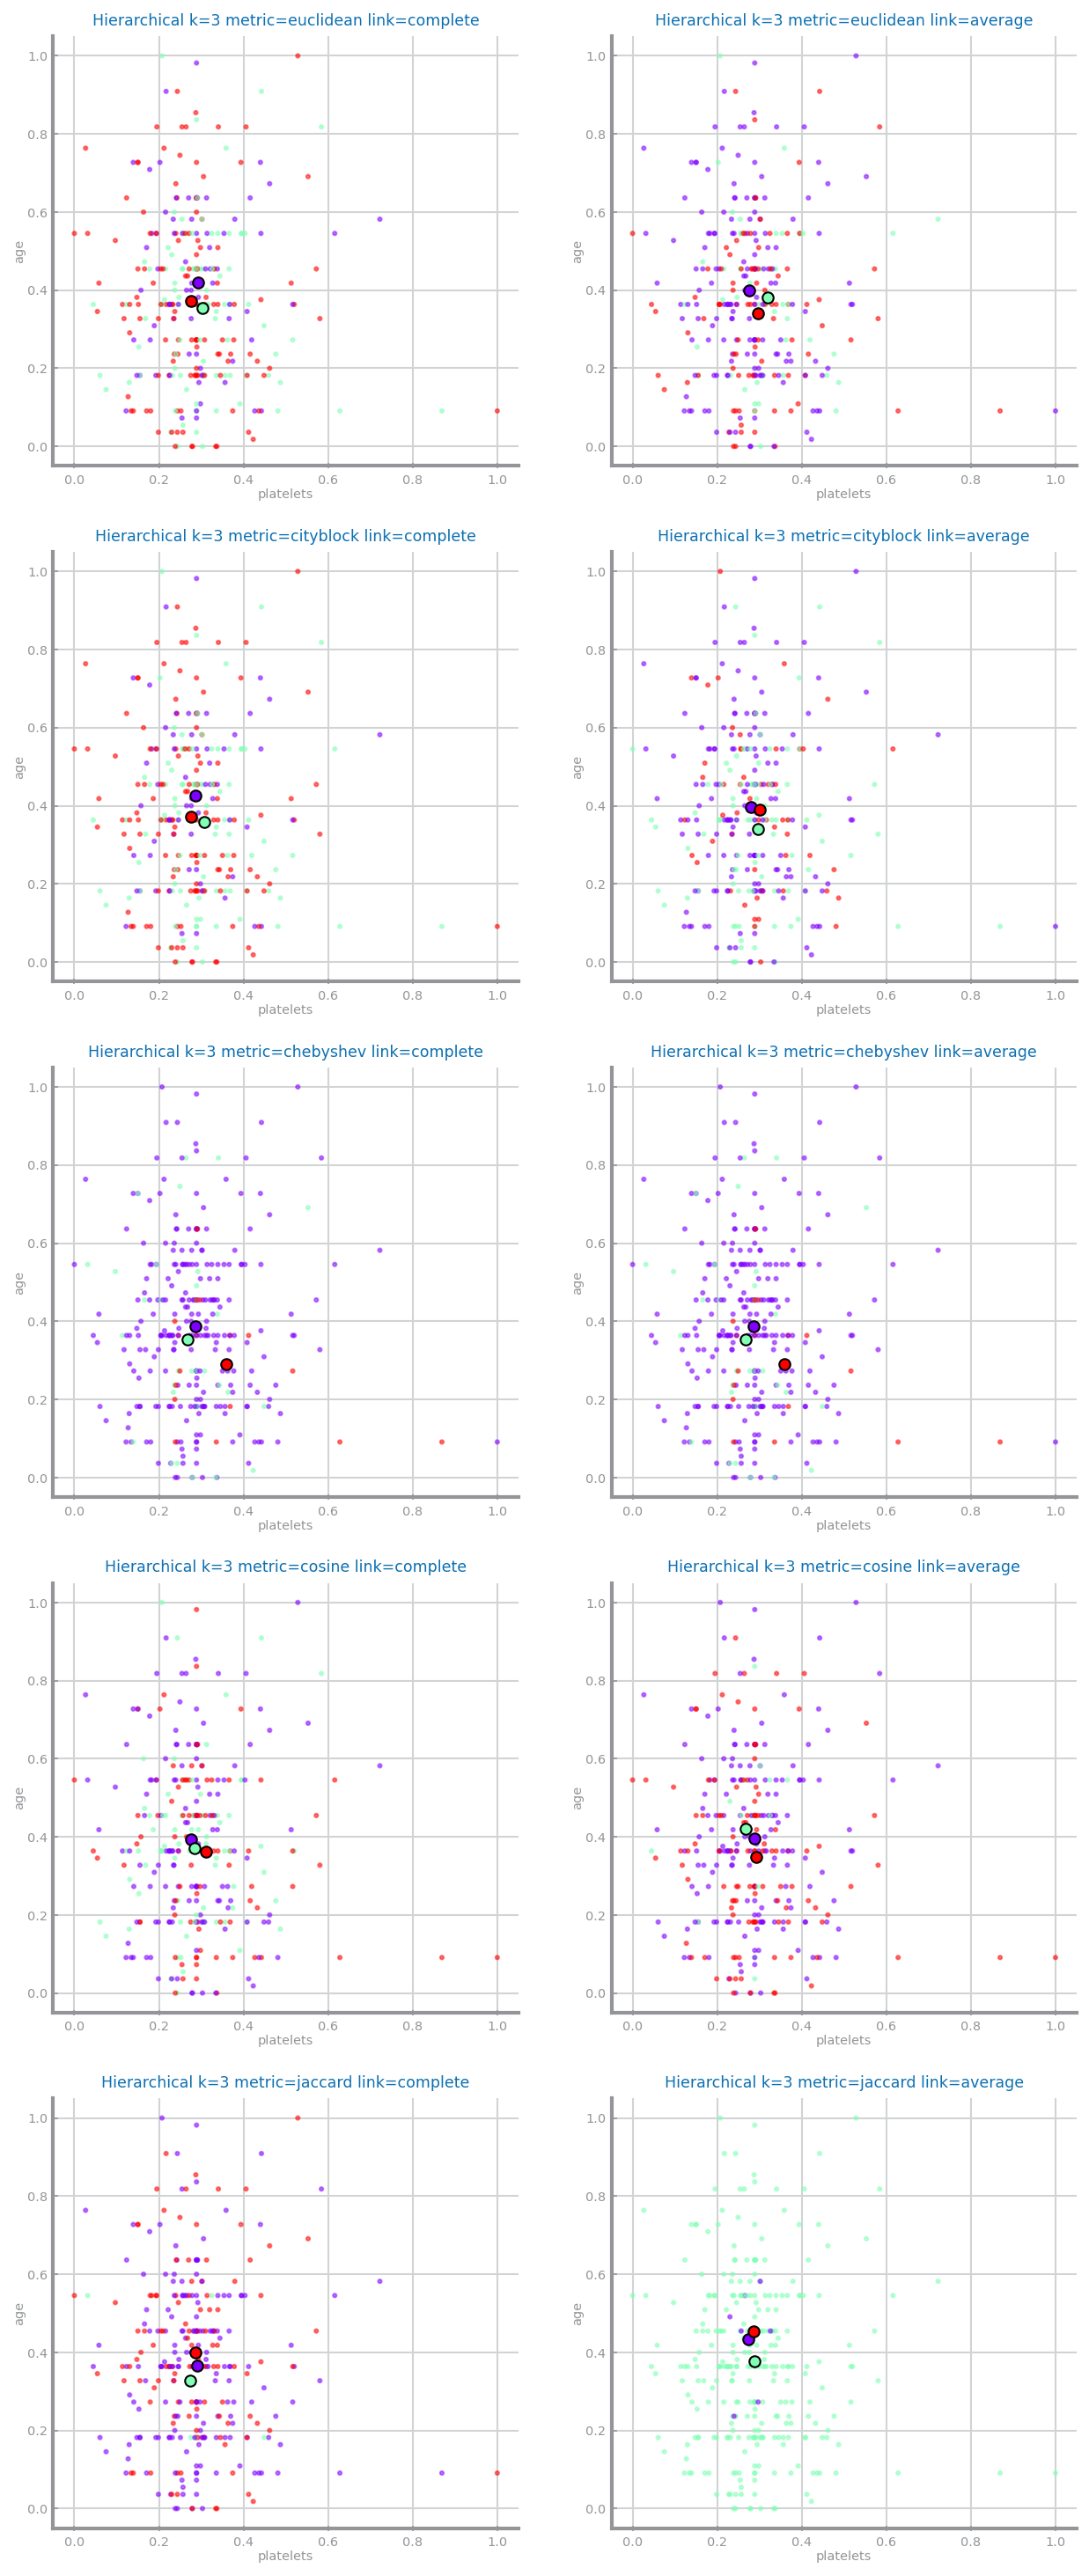

In [13]:
METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard']
LINKS = ['complete', 'average']
k = 3
values_mse = {}
values_sc = {}
rows = len(METRICS)
cols = len(LINKS)
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
for i in range(len(METRICS)):
    mse: list = []
    sc: list = []
    m = METRICS[i]
    for j in range(len(LINKS)):
        link = LINKS[j]
        estimator = AgglomerativeClustering(n_clusters=k, linkage=link, affinity=m )
        estimator.fit(data)
        labels = estimator.labels_
        centers = ds.compute_centroids(data, labels)
        mse.append(ds.compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        ds.plot_clusters(data, v2, v1, labels, centers, k,
                         f'Hierarchical k={k} metric={m} link={link}', ax=axs[i,j])
    values_mse[m] = mse
    values_sc[m] = sc
plt.show()


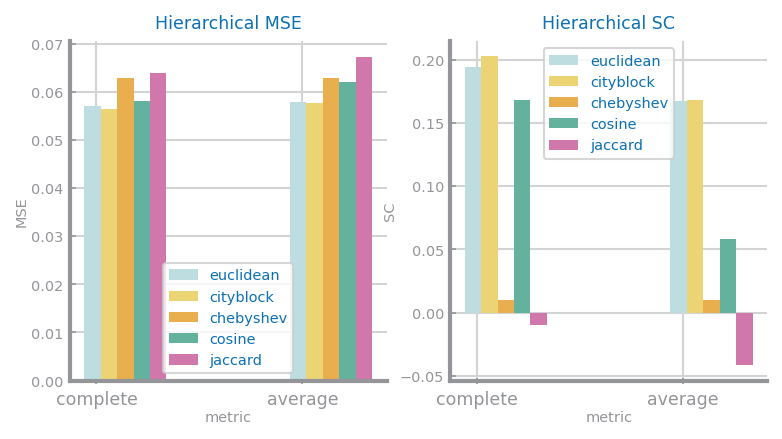

In [14]:
_, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.multiple_bar_chart(LINKS, values_mse, title=f'Hierarchical MSE', xlabel='metric', ylabel='MSE', ax=ax[0, 0], showXTickLabels=True)
ds.multiple_bar_chart(LINKS, values_sc, title=f'Hierarchical SC', xlabel='metric', ylabel='SC', ax=ax[0, 1], showXTickLabels=True)
plt.show()

## Conclusions
---

- SC always seems to be low
- MSE seems to decrease as number of clusters increase